## ***Jupyter Notebook to accompany the paper:***
    
# ***Embracing uncertainty to resolve polar wander: a case study of Cenozoic North America***

### ***by L. C. Gallo<sup>1<sup>*** *(len.gallo@gmail.com)****, M. Domeier<sup>1</sup>, F. Sapienza<sup>2</sup>, N. Swanson-Hysell<sup>3</sup>, B. Vaes<sup>4</sup>, Y. Zhang<sup>3</sup>, M. Arnaould<sup>5</sup>, A. Eyster<sup>6</sup>,  D. Gürer<sup>7</sup>, A. Kiraly<sup>1</sup>, B. Robert<sup>8</sup>, T. Rolf<sup>1</sup>, G. Shephard<sup>1</sup> and A. van der Boon<sup>1</sup>***

*(1) Centre for Earth Evolution and Dynamics, University of Oslo, Norway.*
*(2) Department of Statistics, University of California, Berkeley, United States.*
*(3) Department of Earth and Planetary Science, University of California, Berkeley, United States.*
*(4) Department of Earth Sciences, Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands.*
*(5) Laboratoire de Géologie de Lyon - Terre, Planètes, Environnement, University Lyon 1 Claude Bernard, Lyon, France*
*(6) Department of Geoscience, University of Wisconsin-Madison, Madison, WI USA*
*(7) Research School of Earth Sciences, Australian National University, Canberra, Australian Capital Territory, Australia.*
*(8) Institut de Physique du Globe de Paris, Université de Paris, Paris, France.*




# - Monte Carlo uncertainty propagation scheme from site-level directional data

This notebook illustrates the implementation of Section 2.2 in Gallo et al. (2023)

## * __Import scientific Python libraries__

__Import python libraries as well as functions written for the project within vgptools.__

In [17]:
import os
import numpy as np
import pandas as pd

from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cartopy.crs as ccrs

from vgptools.utils import (spherical2cartesian, cartesian2spherical, 
                               shape, PD, eigen_decomposition,
                               GCD_cartesian, get_angle)
from vgptools.utils_visualization import plot_pole_A95, plot_pole
from vgptools.utils_classes import PC, quantiles

np.random.seed(10)

## 1. __Gather all site-level data from the collection of study-level paleopoles__
In order to gather all the directions in one DataFrame `df_directions` we follow the workflow outlined in Notebook `1_Compile.ipynb` whose output corresponds to a _.csv_ file that we import here to save computing time.

In [2]:
current_path = os.getcwd()
data_path = os.path.join(current_path, '..', 'data')
df_directions = pd.read_csv(data_path +'/vgps_filtered.csv')

## 2. The following function generates a bootstrap sample $X_b$ from the original dataset $X$. Then, it uses Monte Carlo resampling to generate for each site-level sample $X_{bi}$:
- a direction $\hat \mu_{bi}$ from the probability distribution $\text{Fisher}(\mu_i, \kappa_i)$
- an age $\hat t_{bi}$ from $N(t_i, \sigma_i)$ or $U(t_{max}, t_{max})$ (depending on whether $i$ is radiometrically or stratigraphically constrained, respectively)
- For each $X_{bi}$, calculate and store $VGP_{bi}$ and associated age $\hat t$.

In [3]:
def get_vgps_sampling_from_direction(df, study_label= 'Study',
                                     slat_label='slat', slon_label='slon', 
                                     dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                                     mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age'):
    
    '''
    Input:
    
    DF with the following site-level information: 
    - Study, site coordinates, mean direction, concentration parameter, mean age and error distribution. 
    
    Steps:
    1. generate a pseudo-sample from the original dataset using nonparametric random sampling 
    with replacement (bootstrap sample).
    2. For each row (site-level entry) in the bootstrap sample draws a random direction following 
    the kappa concentration parameter and mean direction. 
    3. Assing an age to the entry samopling from the corresponding error distribution
    3. For each row, calculates the correspongin VGP. 
    
    Note: input directions must be all in the same mode (sensu pmagPy) so that we get coherent vgps. 
    Given that we want southern hemisphere vgps, we will work with reversed (<0) inclinations (step already
    done in 0_Preprocessing.ipynb)    
    
    Output:
    
    - A DataFrame with the same size than the original dataset, with randomized parameters.  
    '''    
    Study, age_bst, decs, incs, slat, slon, indexes = [], [], [], [], [], [], [] # parameters of the pseudo-sample to be filled
    
    k_mean = df[k_label].mean() # if site-level data has no reported kappa, we take the mean of the population instead.
    
    # df_pseudo = df.sample(frac = 1, replace = True) # generates a bootstrapped sample of the dataframe by randomly sampling with replacement
    
    for index, row in df.iterrows():        
        
        # we first generate one random direction from the original entry.
        kappa = k_mean if np.isnan(row[k_label]) else row[k_label] # if we don't have kappa, we take the mean of the reported ones       
        n = 3 if np.isnan(row.n) else int(row.n)
        
        # directions_temp = ipmag.fishrot(k = kappa, n = 1, dec = row[dec_label], inc = row[inc_label], di_block = False)
        directions_temp = ipmag.fishrot(k = kappa, n = n, dec = row[dec_label], inc = row[inc_label], di_block = False)        
        site_mean = ipmag.fisher_mean(dec = directions_temp[0], inc = directions_temp[1])        
        
        decs.append(site_mean['dec'])
        incs.append(site_mean['inc'])        
        # decs.append(directions_temp[0][0])
        # incs.append(directions_temp[1][0])
        slat.append(row[slat_label])
        slon.append(row[slon_label])
        indexes.append(index)
        Study.append(row[study_label])
        
        # Assessing the uncertianty distribution (uniform or normal)
        if row.uncer_dist == 'uniform':
            age_bst.append(np.random.randint(np.floor(row[min_age_lab]),np.ceil(row[max_age_lab])))
        else:            
            age_bst.append(np.random.normal(row[mean_age_lab], (row[max_age_lab] - row[mean_age_lab]) / 2)) 
            # the files were completed in such a way to have min and max ages, so we take sigma as a half of that range
    
    dictionary = {
                  'Study': Study,
                  'age': age_bst,
                  'dec': decs,    
                  'inc': incs,
                  'slat': slat,
                  'slon': slon 
                  }    
    new_df = pd.DataFrame(dictionary)        
       
    #new_df['plon'] = new_df.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1)
    new_df['plon'] = pmag.dia_vgp(new_df['dec'], new_df['inc'], 1, new_df['slat'], new_df['slon'])[0]
    
    #new_df['plat'] = new_df.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)
    new_df['plat'] = pmag.dia_vgp(new_df['dec'], new_df['inc'], 1, new_df['slat'], new_df['slon'])[1]
    
    # set longitude in [-180,180]
    #new_df['plon'] = new_df.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)
    new_df['plon'] = new_df['plon'].where(new_df['plon'] <= 180, new_df['plon'] - 360)

    new_df.index = indexes

    return new_df

2. The following function performs a weighted Moving average and gets its descriptive parameters:

In [4]:
def weighted_moving_average_APWP(data, plon_label = 'plon', plat_label='plat', age_label = 'age',window_length=20, time_step=1, max_age=65, min_age=0):
    """
    Returns a data frame with a running mean (Moving average) APWP..
    
    Parameters: 
    - Data Frame with the folowing columns that need to be set [['vgp_lat'],['vgp_lon'],['age']]
    - time-step of the moving average (in Ma)
    - window size of the moving average (in Ma)
    
    * it also calculates descriptive parameters for the underlying distribution of VGPs within each window, e.g. : 
    - Number of VGPs,
    - Angular dispersion
    - Concentration
    - Shape (expressed as foliation, lineation, coplanarity and collinearity)
     
    * the APWP can also be described with some parameters, e.g.:
    - Apparent Polar wander rate (in degrees per Ma) between each time interval

    """
    
    mean_pole_ages = np.arange(min_age, max_age + time_step, time_step)
    
    running_means = pd.DataFrame(columns=['age','N','n_studies','k','A95','csd','plon','plat', 'foliation','lineation','collinearity','coplanarity','elong_dir',
                                         'effective_age','effective_age_std','effective_age_median','distance2age'])
    
    for age in mean_pole_ages:
        window_min = age - (window_length / 2.)
        window_max = age + (window_length / 2.)
        poles_ = data.loc[(data[age_label] >= window_min) & (data[age_label] <= window_max)]
        
        # weights = [(1-0.1)*(1-(np.abs( row.age - age ) / ((max_age - min_age) / 2)))+0.1 for i, row in poles.iterrows()]
        weights = [(1-(np.abs( row.age - age ) / ((window_max - window_min) / 2))) for i, row in poles_.iterrows()]
        poles = poles_.sample(n = len(poles_), weights = weights, replace = True)
        
        if poles.empty: continue
        
        number_studies = len(poles['Study'].unique())
        mean = ipmag.fisher_mean(dec=poles[plon_label].tolist(), inc=poles[plat_label].tolist())
        
        effective_age_mean = np.round(poles[age_label].to_numpy().mean()) #
        effective_age_sd = poles[age_label].to_numpy().std()
        distance2age = np.round(np.random.normal(effective_age_mean, effective_age_sd) - age)
        
        effective_age_median = np.round(np.median(poles[age_label].to_numpy()))
        
        ArrayXYZ = np.array([spherical2cartesian([np.radians(i[plat_label]), np.radians(i[plon_label])]) for _,i in poles.iterrows()])        
        if len(ArrayXYZ) > 3:
            shapes = shape(ArrayXYZ)
            PrinComp=PD(ArrayXYZ)
            eVal, eVec = eigen_decomposition(ArrayXYZ)
            elong_dir = np.degrees(cartesian2spherical(eVec[:,1]))[1] # from T&K2004 (declination od the intermediate Evec)
            # mean['inc']=np.degrees(cartesian2spherical(PrinComp))[0]
            # mean['dec']=np.degrees(cartesian2spherical(PrinComp))[1]
        else:
            shapes = [np.nan,np.nan,np.nan,np.nan]
        
        if len(poles)>2: #ensures that dict isn't empty
            running_means.loc[age] = [age, mean['n'], number_studies, mean['k'],mean['alpha95'], mean['csd'], mean['dec'], mean['inc'], 
                                      shapes[0], shapes[1], shapes[2], shapes[3], elong_dir,
                                     effective_age_mean, effective_age_sd, effective_age_median, distance2age]
    # Set longitudes in [-180, 180]
    running_means['plon'] = running_means.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)   
    
    # The following block calculates rate of polar wander (degrees per million years) 
    running_means['PPcartesian'] = running_means.apply(lambda row: spherical2cartesian([np.radians(row['plat']),np.radians(row['plon'])]), axis = 1)
    running_means['PP_prev'] = running_means['PPcartesian'].shift(periods = 1)
    running_means['PP_next'] =  running_means['PPcartesian'].shift(periods = -1)
    running_means['GCD'] = running_means.apply(lambda row: np.degrees(GCD_cartesian(row['PP_prev'], row['PPcartesian'])), axis = 1)
    running_means['APW_rate'] = running_means['GCD']/running_means['age'].diff()

    running_means['APW_rate_eff_age'] = running_means['GCD']/running_means['effective_age'].diff().replace(0, np.nan, inplace=False)
    
    # Calculate a 'kink' angle for each position of the path
    running_means['angle'] = running_means.apply(lambda row: get_angle(row['PP_prev'], row['PPcartesian'], row['PP_next']), axis = 1)

    running_means = running_means.drop(['PPcartesian', 'PP_prev', 'PP_next'], axis=1)      
    running_means.reset_index(drop=1, inplace=True)
    
    #set the present day field for the present
    running_means['plat'] = np.where(running_means['age']==0, -90, running_means['plat'])
    running_means['plon'] = np.where(running_means['age']==0, 0, running_means['plon'])
    
    return running_means


3. The following function performs the previous procedure a number of times a stores for each run the Moving Average along with their descriptive parameters

In [5]:
def ensemble_RMs(df_vgps_original, n_sims = 100, 
                 study_label= 'Study', slat_label='slat', slon_label='slon', 
                 dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                 mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age',
                 plon_label = 'plon', plat_label='plat', age_label = 'age',
                 window_length=20, time_step=1, max_age=65, min_age=0):
    
    '''
    This function gets the pooled directions and return the ensemble Moving Averages following the workflow of Gallo et al. (2023) 
    '''
    
    running_means_global = pd.DataFrame(columns=['run','N','k','A95','csd','foliation','lineation','collinearity','coplanarity'])
    
    for i in range(n_sims):
    
        # Generate a pseudo-sample of the original dataset in which every entry is a pseudo-sample taken for the error PDF
        pseudo_df = get_vgps_sampling_from_direction(df_vgps_original, study_label= study_label,
                                             slat_label=slat_label, slon_label=slon_label, 
                                             dec_label=dec_label, inc_label=inc_label, k_label=k_label,
                                             mean_age_lab=mean_age_lab, min_age_lab=min_age_lab, max_age_lab=max_age_lab)

        # Construct a Moving Average on the former data-set
        RM = weighted_moving_average_APWP(pseudo_df, plon_label = 'plon', plat_label='plat', age_label = 'age', 
                            window_length=window_length, time_step=time_step, max_age=max_age, min_age=min_age)
 
        RM['run'] = float(i)
        running_means_global = running_means_global.append(RM, ignore_index=True)

    running_means_global['plon'] = running_means_global['plon'].where(running_means_global['plon'] <= 180, running_means_global['plon'] - 360)
    return running_means_global

# Run an ensemble of Moving Avergaes:

First, we set the parameters of the moving average

In [6]:
# Set the parameters for the Moving average
window_length= 21
time_step= 1 
max_age= 60
min_age= 0

## 4. We now proceed to run the workflow a great number of times in order to to get the ensemble statistics.

In [8]:
%%time
np.random.seed(10)
df_RM_ensemble = ensemble_RMs(df_directions, n_sims = 500,
                 study_label= 'Study', slat_label='slat', slon_label='slon',
                 dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                 mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age',
                 plon_label = 'plon', plat_label='plat', age_label = 'age',
                 window_length=window_length, time_step=time_step, max_age=max_age, min_age=min_age)

CPU times: user 17min 45s, sys: 6.61 s, total: 17min 52s
Wall time: 17min 53s


# Visualization Using the effective age as the age of the window

### First we need to calculate the time-varying Ensemble statistics 
We take advantage of the groupby method to perform the statistics of each parameter of interest in the entire datade grouped by effective age

quantile() and PC() are classes aiding this calculations

## Calculate APW rate from the ensemble poles

In [9]:
ensemble_rates = pd.DataFrame()
for j in range(100):
    df = pd.DataFrame()
    for i in np.sort(df_RM_ensemble['effective_age'].unique()):
        pole = df_RM_ensemble[df_RM_ensemble['effective_age'] == i].sample(n=1)
        df = df.append(pole)
    # The following block calculates rate of polar wander (degrees per million years) 
    df['run'] = j
    df['PPcartesian'] = df.apply(lambda row: spherical2cartesian([np.radians(row['plat']),np.radians(row['plon'])]), axis = 1)
    df['PP_prev'] = df['PPcartesian'].shift(periods = 1)
    df['PP_next'] =  df['PPcartesian'].shift(periods = -1)
    df['GCD'] = df.apply(lambda row: np.degrees(GCD_cartesian(row['PP_prev'], row['PPcartesian'])), axis = 1)
    df['APW_rate'] = df['GCD']/df['effective_age'].diff()
    ensemble_rates = ensemble_rates.append(df)

In [10]:
# Set the level confidence at which we want to work 
quantile = 95

# Since the Latitude and Longitude covaries, we need to calculate the Principal component for each timre-dependant point Cloud 
# the class PC() has also methods to aid in the calculatrio
ensemble_PC_eff_age = PC(df_RM_ensemble,"effective_age","plat","plon") # set principal component for each Age

# # Ensemble's parameters (e.g. Apparent polar wander rate, age difference)
ensemble_apw_eff = quantiles(df_RM_ensemble,"effective_age","APW_rate") # set quantiles of latitude groupedby age for visualization purposes
ensemble_apw_ef_ = quantiles(ensemble_rates,"effective_age","APW_rate") # set quantiles of latitude groupedby age for visualization purposes

## Time varying Latitude and Longitudes visualization

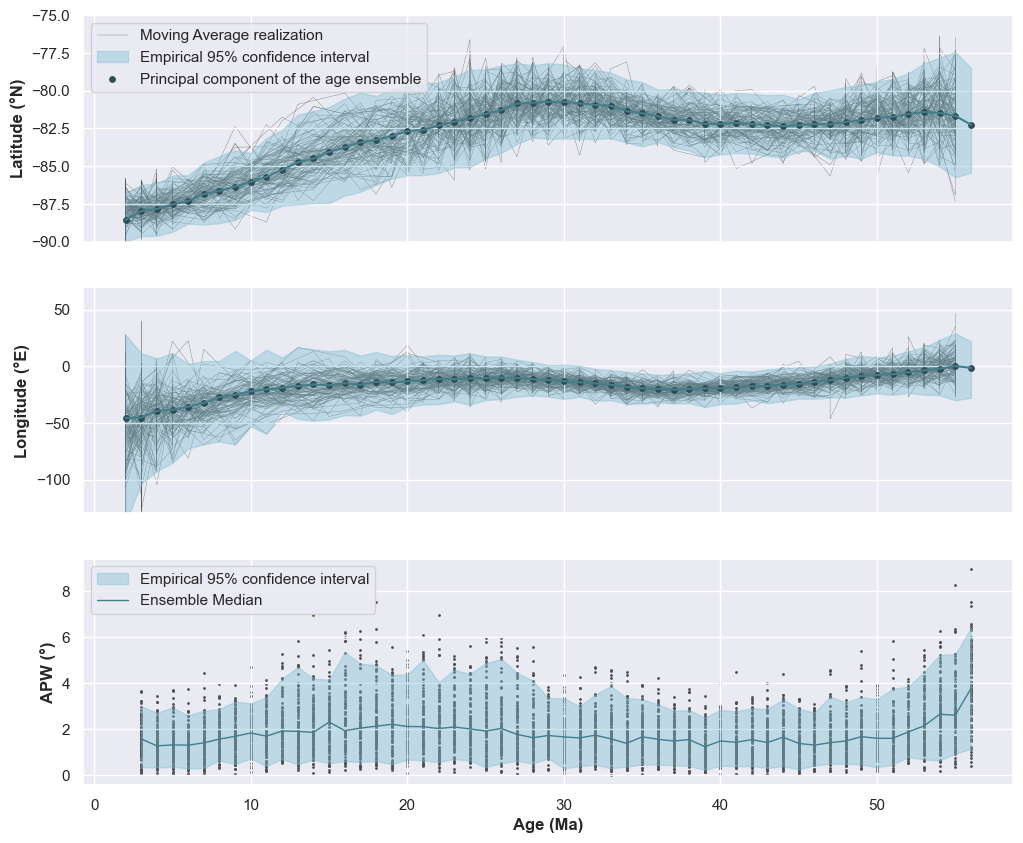

In [11]:
sns.reset_orig
sns.set_theme(style="darkgrid")
# sns.set_theme(style="white", palette=None)
fig, axes = plt.subplots(3, 1, figsize=(12,10), sharex=True)

# Set Axis Labels
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold', fontsize = 12)
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold', fontsize = 12)
axes[2].set_ylabel(r'APW (°)', fontweight ='bold', fontsize = 12)
axes[2].set_xlabel(r'Age (Ma)', fontweight ='bold', fontsize = 12)

# plot 50 runs to save computational cost and very dense graphics 
df_RM_ensemble_50 = df_RM_ensemble[df_RM_ensemble['run'].isin(range(0,100))]

# LATITUDES 
for run, df_run in df_RM_ensemble_50.groupby('run'):
    axes[0].plot(df_run.effective_age.tolist(), df_run.plat.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2)
axes[0].plot(df_run.effective_age.tolist(), df_run.plat.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2, label = 'Moving Average realization')
axes[0].fill_between(ensemble_PC_eff_age.X, ensemble_PC_eff_age.Lat_Lon_bounds(quantile)[2], ensemble_PC_eff_age.Lat_Lon_bounds(quantile)[3], color= "#7DBFD2", alpha=.40, zorder =1, label=f"Empirical {quantile}% confidence interval")
axes[0].scatter(ensemble_PC_eff_age.X, ensemble_PC_eff_age.PC(quantile)[1],color="#314B54", s = 15,  label = 'Principal component of the age ensemble')  
axes[0].plot(ensemble_PC_eff_age.X, ensemble_PC_eff_age.PC(quantile)[1],color="#427E8C")  
    
# LONGITUDES     
for run, df_run in df_RM_ensemble_50.groupby('run'):
    axes[1].plot(df_run.effective_age.tolist(), df_run.plon.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2)
axes[1].plot(df_run.effective_age.tolist(), df_run.plon.tolist(), color="#4F4F4F", zorder =0, linewidth=0.2, label = 'Moving Average realization')
axes[1].fill_between(ensemble_PC_eff_age.X, ensemble_PC_eff_age.Lat_Lon_bounds(quantile)[0], ensemble_PC_eff_age.Lat_Lon_bounds(quantile)[1], color= "#7DBFD2", alpha=.40, zorder =1, label=f"Empirical {quantile}% confidence interval")
axes[1].scatter(ensemble_PC_eff_age.X, ensemble_PC_eff_age.PC(quantile)[0],color="#314B54", s = 15,  label = 'Principal component of the age ensemble')
axes[1].plot(ensemble_PC_eff_age.X, ensemble_PC_eff_age.PC(quantile)[0],color="#427E8C")  

# red = ##7F4141
for run, df_run in ensemble_rates.groupby('run'):
    axes[2].scatter(df_run.effective_age.to_numpy()[df_run.effective_age.to_numpy() > 2], df_run.APW_rate.to_numpy()[df_run.effective_age.to_numpy() > 2], color="#4F4F4F", zorder =0, s=1)
axes[2].fill_between(np.sort(ensemble_apw_ef_ .X)[1:], ensemble_apw_ef_ .q5[1:],ensemble_apw_ef_ .q95[1:], color= "#7DBFD2", alpha=.40, zorder =1, label=f"Empirical {quantile}% confidence interval")
axes[2].plot(np.sort(ensemble_apw_ef_ .X), ensemble_apw_ef_ .q50,color="#427E8C", zorder =3, linewidth=1, label="Ensemble Median")

axes[0].set_ylim(-90,-75)
axes[1].set_ylim(-130,70)
# axes[2].set_ylim(0,6.5)
axes[0].legend(loc="upper left")
axes[2].legend(loc="upper left")
# plt.savefig(os.path.join(current_path, '..') + '/figures/3/ensemble.svg', dpi =600, bbox_inches='tight')   

### Visualizing the actual path

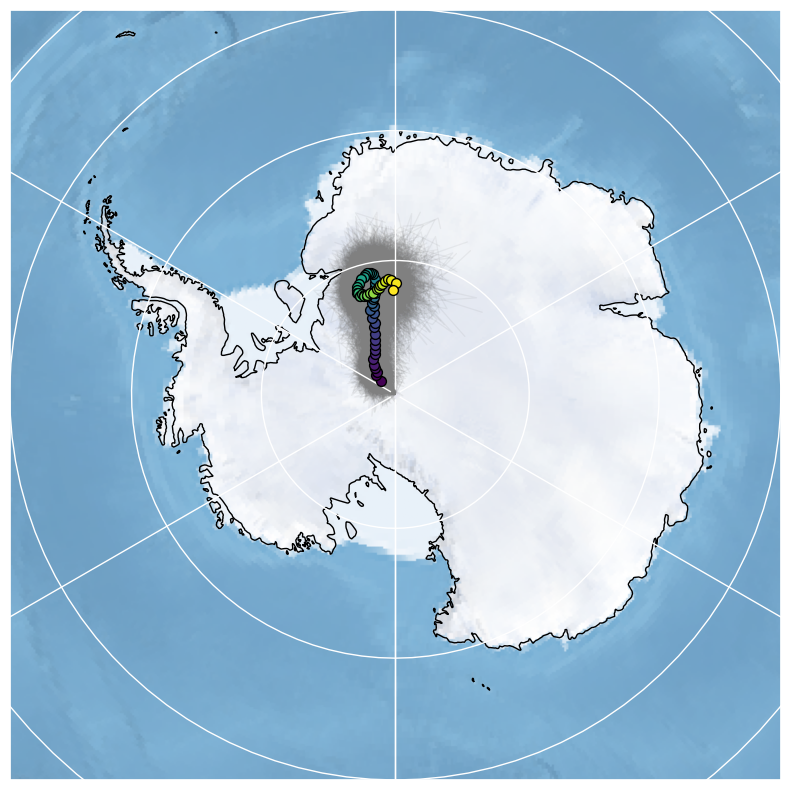

In [12]:
# Visualization

extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())



# A black path for the time-varying Principal Component.
plt.plot(ensemble_PC_eff_age.PC(quantile)[0].tolist(), ensemble_PC_eff_age.PC(quantile)[1].tolist(),transform = ccrs.Geodetic(), color = "black", alpha = 1, linewidth=1.5, zorder=1)

    
for i in zip(ensemble_PC_eff_age.PC(quantile)[1].tolist(), ensemble_PC_eff_age.PC(quantile)[0].tolist(),ensemble_PC_eff_age.X.tolist(), ensemble_PC_eff_age.X.tolist()):
    plot_pole(i[0],i[1],i[2],ensemble_PC_eff_age.X.min(),ensemble_PC_eff_age.X.max(),ax)
    
# Runs in grey
for run, df_run in df_RM_ensemble[df_RM_ensemble['run']<500].groupby('run'):
    plt.plot(df_run.plon.tolist(), df_run.plat.tolist(),transform = ccrs.Geodetic(), color = "grey", alpha = 0.1, linewidth=0.9,  zorder=0) #linewidth=0.8,

# plt.savefig(os.path.join(current_path, '..')  + '/figures/3/path.svg', dpi =600, bbox_inches='tight')
plt.show()

### Add Theta 95

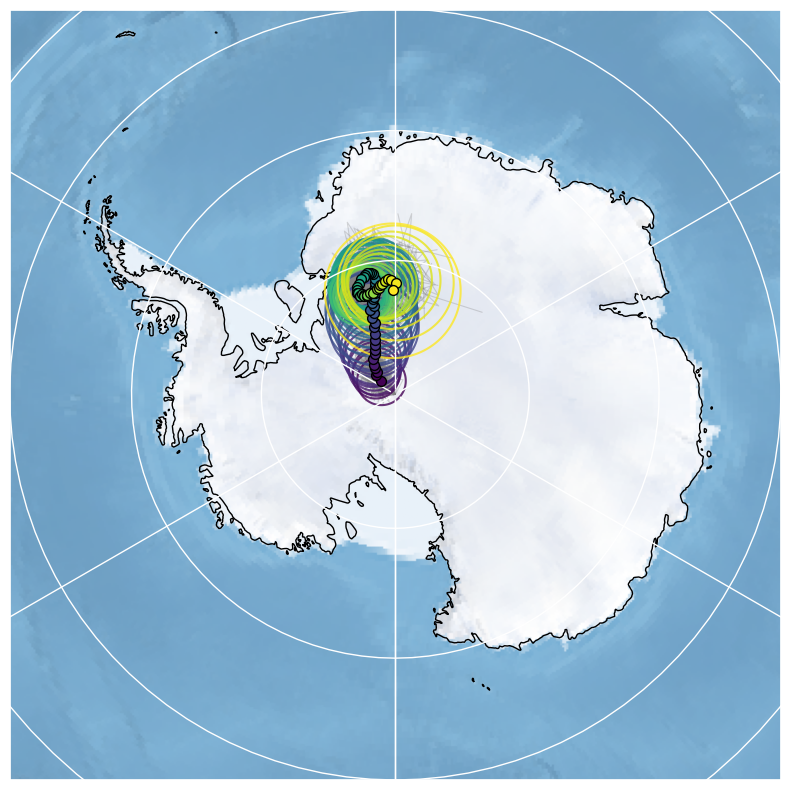

In [14]:
# Visualization

extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# A black path for the time-varying Principal Component.
plt.plot(ensemble_PC_eff_age.PC(quantile)[0].tolist(), ensemble_PC_eff_age.PC(quantile)[1].tolist(),transform = ccrs.Geodetic(), color = "black", alpha = 1, linewidth=1.5, zorder=1)
    
for i in zip(ensemble_PC_eff_age.PC(quantile)[1].tolist(), ensemble_PC_eff_age.PC(quantile)[0].tolist(), ensemble_PC_eff_age.PC(quantile)[2].tolist(),ensemble_PC_eff_age.X.tolist(), ensemble_PC_eff_age.X.tolist()):
    plot_pole_A95(i[0],i[1],i[2],i[3], ensemble_PC_eff_age.X.min(),ensemble_PC_eff_age.X.max(),ax)    

# Runs in grey (just plotting 50 runs)
for run, df_run in df_RM_ensemble[df_RM_ensemble['run']<50].groupby('run'):
    plt.plot(df_run.plon.tolist(), df_run.plat.tolist(),transform = ccrs.Geodetic(), color = "grey", alpha = 0.3, linewidth=0.8, zorder=0)

# plt.savefig(os.path.join(current_path, '..')  + '/figures/3/path_theta.svg', dpi =600, bbox_inches='tight')
plt.show()

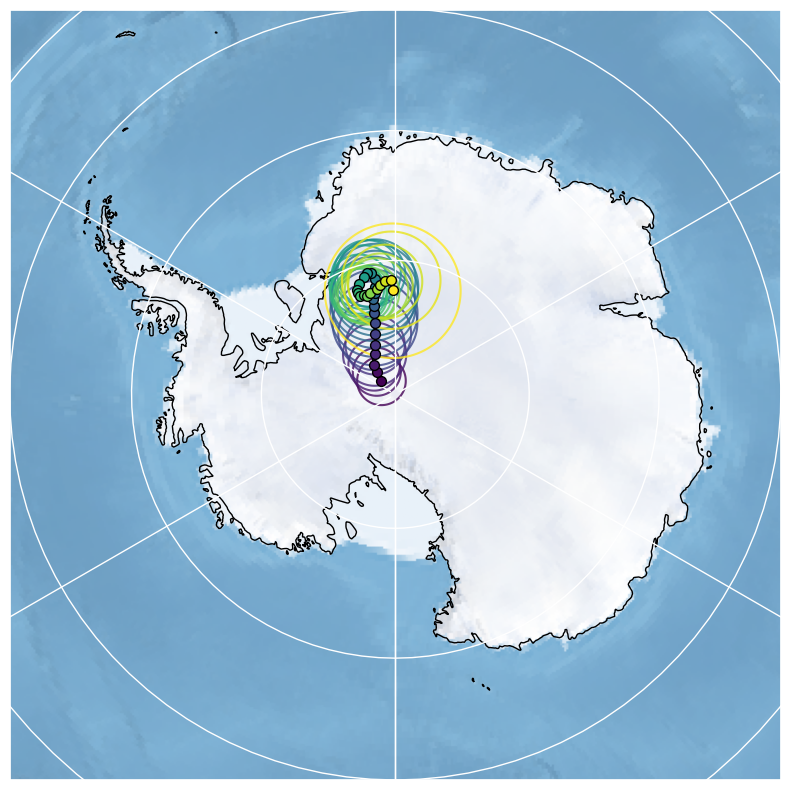

In [15]:
# Visualization

extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())


# A black path for the time-varying Principal Component.
plt.plot(ensemble_PC_eff_age.PC(quantile)[0].tolist(), ensemble_PC_eff_age.PC(quantile)[1].tolist(),transform = ccrs.Geodetic(), color = "black", alpha = 1, linewidth=1.5, zorder=1)
    
    
for i in zip(ensemble_PC_eff_age.PC(quantile)[1].tolist(), ensemble_PC_eff_age.PC(quantile)[0].tolist(), ensemble_PC_eff_age.PC(quantile)[2].tolist(),ensemble_PC_eff_age.X.tolist(), ensemble_PC_eff_age.X.tolist()):
    if i[3]%2==0: #plot even ages
        plot_pole_A95(i[0],i[1],i[2],i[3], ensemble_PC_eff_age.X.min(),ensemble_PC_eff_age.X.max(),ax)    

# Runs in grey (just plotting 50 runs)
# for run, df_run in df_RM_ensemble[df_RM_ensemble['run']<50].groupby('run'):
#     plt.plot(df_run.plon.tolist(), df_run.plat.tolist(),transform = ccrs.Geodetic(), color = "grey", alpha = 0.3, linewidth=0.8, zorder=0)

# plt.savefig(os.path.join(current_path, '..')  + '/figures/3/path_theta.svg', dpi =600, bbox_inches='tight')
plt.show()

## Kent ellipses

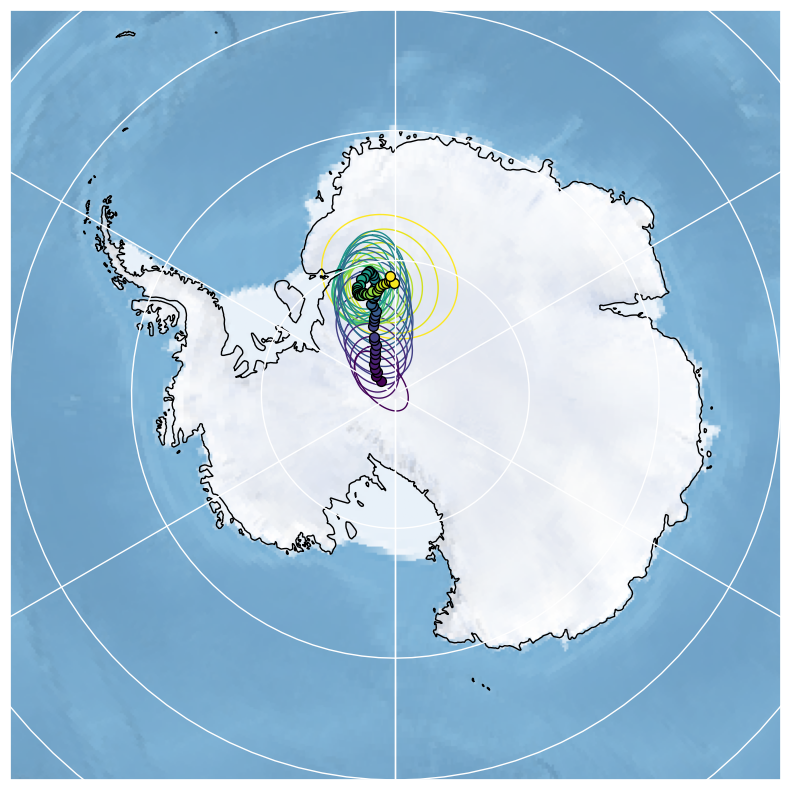

In [68]:
extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())


cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(df_RM_ensemble['effective_age'].unique().min(), df_RM_ensemble['effective_age'].unique().max())

for age in df_RM_ensemble['effective_age'].unique()[::-1]:
    if age%2==0:
        sample =   df_RM_ensemble[df_RM_ensemble['effective_age'] == age]
        # ipmag.plot_vgp(ax, sample['plon'].tolist(), sample['plat'].tolist(), color='lightgrey', edge='none', markersize=5, alpha=0.02)
        kent_stats = ipmag.kent_distribution_95(dec=sample['plon'].tolist(), inc=sample['plat'].tolist()) 
        ipmag.plot_pole_ellipse(ax, kent_stats, color=cmap(norm(age)),lower=False, markersize=1, zorder=1)

for i in zip(ensemble_PC_eff_age.PC(quantile)[1].tolist(), ensemble_PC_eff_age.PC(quantile)[0].tolist(), ensemble_PC_eff_age.PC(quantile)[2].tolist(),ensemble_PC_eff_age.X.tolist(), ensemble_PC_eff_age.X.tolist()):
    plot_pole(i[0],i[1],i[3], ensemble_PC_eff_age.X.min(),ensemble_PC_eff_age.X.max(),ax)       

# for run, df_run in df_RM_ensemble[df_RM_ensemble['run']<50].groupby('run'):
#     plt.plot(df_run.plon.tolist(), df_run.plat.tolist(),transform = ccrs.Geodetic(), color = "grey", alpha = 0.3, linewidth=0.8, zorder=0)

plt.show()

## Contours

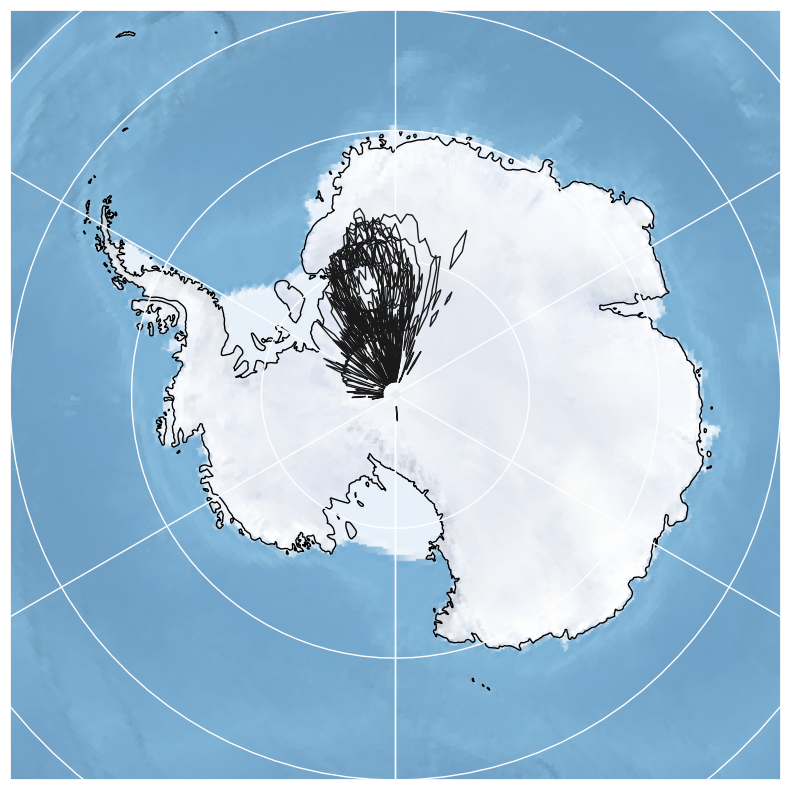

In [43]:
extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(df_RM_ensemble['effective_age'].unique().min(), df_RM_ensemble['effective_age'].unique().max())

for age in df_RM_ensemble['effective_age'].unique()[::-1]:
    if age%2==0:
        sample =   df_RM_ensemble[df_RM_ensemble['effective_age'] == age]
        # ipmag.plot_vgp(ax, sample['plon'].tolist(), sample['plat'].tolist(), color='lightgrey', edge='none', markersize=5, alpha=0.02)
        
        # kent_stats = ipmag.kent_distribution_95(dec=sample['plon'].tolist(), inc=sample['plat'].tolist()) 
        # ipmag.plot_pole_ellipse(ax, kent_stats, color=cmap(norm(age)),lower=False, markersize=1, zorder=1)
        ipmag.plot_distributions(ax, sample['plon'].tolist(), sample['plat'].tolist(), 
                                 to_plot='e', resolution=100, colors= 'k'## cmap(norm(age))
                                )
        
plt.show()

# APWP

In [15]:
apwp_eff = {'Age': ensemble_PC_eff_age.X,
           'Plat': ensemble_PC_eff_age.PC(quantile)[1],
           'Plon': ensemble_PC_eff_age.PC(quantile)[0],
           'Theta 95': ensemble_PC_eff_age.PC(quantile)[2],
           'max lat': ensemble_PC_eff_age.Lat_Lon_bounds(quantile)[3],
           'min lat': ensemble_PC_eff_age.Lat_Lon_bounds(quantile)[2],
           'max lon': ensemble_PC_eff_age.Lat_Lon_bounds(quantile)[1],
           'min lon': ensemble_PC_eff_age.Lat_Lon_bounds(quantile)[0],           
          }
df_apwp_eff = pd.DataFrame(apwp_eff)
df_apwp_eff.head(20)
# df_apwp_eff.to_csv(data_path +'/NAM_Cenozoic_APWP', index = False)

,Age,Plat,Plon,Theta 95,max lat,min lat,max lon,min lon
0,2.0,-88.610072,-46.935252,1.852032,-90.000000,-86.783470,-126.524306,6.477173
1,3.0,-88.002402,-46.248062,1.644850,-89.639998,-86.410118,-90.738915,7.400984
2,4.0,-87.854006,-39.477790,1.637345,-89.282557,-86.222700,-81.914424,3.131206
3,5.0,-87.479822,-38.525967,1.947605,-89.384220,-85.723987,-72.866798,6.208077
4,6.0,-87.134326,-37.636218,2.012895,-88.962817,-85.402753,-67.235748,-6.140198
5,7.0,-86.958090,-30.916504,2.051925,-88.767775,-85.063473,-71.771342,4.680981
6,8.0,-86.635231,-28.993326,1.802521,-88.105616,-85.708844,-59.698225,-2.105562
7,9.0,-86.435942,-26.319465,2.391520,-88.506060,-84.052437,-53.754569,1.992016
8,10.0,-86.188665,-27.630599,2.575415,-87.856108,-83.681227,-50.040199,-4.334738
9,11.0,-85.658716,-19.951343,2.926225,-88.350302,-83.102221,-44.601182,12.154022
